# Deploying the depression RNN in SageMaker

## Imports

In [1]:
import tensorflow as tf
import pandas as pd
import sagemaker
import os
from sagemaker.tensorflow import TensorFlow
import time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print('Done')

Done


## Data import

In [2]:
train = pd.read_csv('train.csv', sep=',',header=None)
test = pd.read_csv('test.csv', sep=',',header=None)

## Creating a session object and uploading data to S3

In [3]:
sage_maker_session = sagemaker.Session()

In [4]:
#This returns the complete s3 path of the data file.
prefix = 'tensorflow-depression-predictions' #The name of the S3 bucket previously created
training_input_path = sage_maker_session.upload_data('train.csv', key_prefix=prefix+'/training')
testing_input_path = sage_maker_session.upload_data('test.csv', key_prefix=prefix+'/testing')

In [5]:
training_input_path

's3://sagemaker-us-east-1-274416698914/tensorflow-depression-predictions/training/train.csv'

In [6]:
testing_input_path

's3://sagemaker-us-east-1-274416698914/tensorflow-depression-predictions/testing/test.csv'

## Exploring the data coming from S3 to double check everything went OK

In [7]:
#Reading the csv file from S3
training_data = pd.read_csv(training_input_path, sep=',',header=None)
testing_data = pd.read_csv(testing_input_path, sep=',',header=None)

In [8]:
training_data.head()

,0,1
0,i have bipolar one borderline personality diso...,0
1,much the same as that plus fear and desperation,0
2,its very common to struggle with work im not a...,0
3,it could but the horror of it all is that you ...,0
4,dont feel shame that only allows the illness t...,0


In [9]:
#training_data[0].values

In [10]:
testing_data.head()

,0,1
0,my kids have one and they love itive tried it ...,1
1,also seroquel relaxes me when i have anxiety a...,1
2,hi i suffer from chronic anxiety disorder and ...,0
3,well im in the fight formylife buti struggle w...,0
4,my doctor switched me to brintellix once and g...,0


In [11]:
#testing_data[0].values

In [12]:
#We're gonna concat the data because we need to train the vectorizer
data = pd.concat([training_data,testing_data], ignore_index=True)
data

,0,1
0,i have bipolar one borderline personality diso...,0
1,much the same as that plus fear and desperation,0
2,its very common to struggle with work im not a...,0
3,it could but the horror of it all is that you ...,0
4,dont feel shame that only allows the illness t...,0
...,...,...
7140,when things get bad i write every thought down...,0
7141,dont give us a placebo give us a fucking curei...,1
7142,its a great medication here and there side eff...,1
7143,last time i had a massive panic attack there w...,0


## Building the train.py file and saving it into the JupyterLab home dir

In [22]:
%%writefile train.py
import argparse
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

if __name__ == '__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=7)
    parser.add_argument('--max_words', type=int, default=20000)
    parser.add_argument('--max_len', type=int, default=400)
    parser.add_argument('--gpu_count', type=int, default=os.environ['SM_NUM_GPUS'])

    # input data and model directories
    parser.add_argument('--model_dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])
    parser.add_argument('--test', type=str, default=os.environ['SM_CHANNEL_TEST'])

    args, _ = parser.parse_known_args()
    
    epochs     = args.epochs
    max_words  = args.max_words
    max_len    = args.max_len
    gpu_count  = args.gpu_count
    model_dir  = args.model_dir
    training_dir   = args.train
    testing_dir   = args.test
    
    training_data = pd.read_csv(training_dir+'/train.csv',sep=',',header=None)
    testing_data = pd.read_csv(testing_dir+'/test.csv',sep=',',header=None)
    
    data = pd.concat([training_data,testing_data], ignore_index=True)
    features = data[0].values
    labels = data[1].values
    
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(features)
    sequences = tokenizer.texts_to_sequences(features)
    features = pad_sequences(sequences, maxlen=max_len)

    vocab_size = len(tokenizer.word_index) 
    
    #Splitting the data again, because we needed to concat it before to train the tokenizer
    X_train, X_test, y_train, y_test = train_test_split(features,labels, random_state=0)

    # Building the model
    model = Sequential()
    model.add(layers.Embedding(max_words, 40))
    model.add(layers.LSTM(40,dropout=0.5))
    model.add(layers.Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=2)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('Model accuracy: ',test_acc)
    
    model_path = '{}/{}/00000001'.format(model_dir, 'depression_classifier')
    tf.saved_model.save(model, model_path)

Overwriting train.py


In [23]:
tf_version = tf.__version__
tf_version

'2.1.0'

## Creating a training job on SageMaker

In [24]:
role = sagemaker.get_execution_role()

In [25]:
#model_dir = '/opt/ml/model'
tf_estimator = TensorFlow(entry_point='train.py', 
                          role=role,
                          #model_dir=model_dir,
                          train_instance_count=1, 
                          train_instance_type='local',
                          framework_version=tf_version, 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={
                              'epochs': 7,
                          }
                         )
# IMPORTANT: Only use *ml.p2.xlarge* instance type because it's the one that the limit has been increased.

In [26]:
training_input_path

's3://sagemaker-us-east-1-274416698914/tensorflow-depression-predictions/training/train.csv'

In [27]:
testing_input_path

's3://sagemaker-us-east-1-274416698914/tensorflow-depression-predictions/testing/test.csv'

In [28]:
#Starting the training, calling the fit method and passing the training and testing data paths. 
#This creates a training job on SageMaker. 
tf_estimator.fit({'train': training_input_path,'test': testing_input_path})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Creating tmpyvmwm5w0_algo-1-yuu5h_1 ... 
Attaching to tmpyvmwm5w0_algo-1-yuu5h_12mdone
algo-1-yuu5h_1  | 2020-09-15 20:36:48,790 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-yuu5h_1  | 2020-09-15 20:36:48,797 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-yuu5h_1  | 2020-09-15 20:36:49,996 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-yuu5h_1  | 2020-09-15 20:36:50,016 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-yuu5h_1  | 2020-09-15 20:36:50,035 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-yuu5h_1  | 2020-09-15 20:36:50,048 sagemaker-containers INFO     Invoking user script
algo-1-yuu5h_1  | 
algo-1-yuu5h_1  | Training Env:
algo-1-yuu5h_1  | 
algo-1-yuu5h_1  | {
algo-1-yuu5h_1  |     "additional_framework_parameters": {},
algo-1-yuu5h_1  |     "channel_input_dirs": {
algo-1-yuu5h_1  

## Deploying the model to SageMaker

In [29]:
endpoint_name = 'tensorflow-depression-predictions'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
end_point = tf_estimator.deploy(initial_instance_count=1,instance_type='ml.p2.xlarge',endpoint_name=endpoint_name)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Attaching to tmp7ykdk46h_algo-1-20k5a_1
algo-1-20k5a_1  | INFO:__main__:starting services
algo-1-20k5a_1  | INFO:__main__:using default model name: depression_classifier
algo-1-20k5a_1  | INFO:__main__:tensorflow serving model config: 
algo-1-20k5a_1  | model_config_list: {
algo-1-20k5a_1  |   config: {
algo-1-20k5a_1  |     name: "depression_classifier",
algo-1-20k5a_1  |     base_path: "/opt/ml/model/depression_classifier",
algo-1-20k5a_1  |     model_platform: "tensorflow"
algo-1-20k5a_1  |   }
algo-1-20k5a_1  | }
algo-1-20k5a_1  | 
algo-1-20k5a_1  | 
algo-1-20k5a_1  | INFO:__main__:nginx config: 
algo-1-20k5a_1  | load_module modules/ngx_http_js_module.so;
algo-1-20k5a_1  | 
algo-1-20k5a_1  | worker_processes auto;
algo-1-20k5a_1  | daemon off;
algo-1-20k5a_1  | pid /tmp/nginx.pid;
algo-1-20k5a_1  | error_log  /dev/stderr info;
algo-1-20k5a_1  | 
algo-1-20k5a_1  | worker_rlimit_nofile 4096;
algo-1-20k5a_1  | 
algo-1-20k5a_1  | events {
algo-1-20k5a_1  |   worker_connections 2048;
a

In [30]:
print(end_point.endpoint)

tensorflow-depression-predictions2020-09-15-20-46-29


## Validating the model

In [31]:
def preprocess_texts(text):
    
    max_words = 20000
    max_len = 400

    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(data[0].values)
    sequences = tokenizer.texts_to_sequences(text)
    sequences = pad_sequences(sequences, maxlen=max_len)
    
    return sequences

In [32]:
test_texts = preprocess_texts(testing_data[0].values)

In [35]:
test_texts

array([[   0,    0,    0, ...,  256,    6, 4803],
       [   0,    0,    0, ...,   15,  553,  144],
       [   0,    0,    0, ..., 1537,   53,  314],
       ...,
       [   0,    0,    0, ...,  235,    3,    5],
       [   0,    0,    0, ...,  117, 1385,   15],
       [   0,    0,    0, ...,    5,    2,  232]], dtype=int32)

In [36]:
import numpy as np
predictions = end_point.predict(test_texts)

algo-1-20k5a_1  | 172.18.0.1 - - [15/Sep/2020:20:49:18 +0000] "POST /invocations HTTP/1.1" 200 27989 "-" "-"


In [39]:
np.around(predictions['predictions'], decimals=0)

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]])

In [42]:
testing_data[1]

0       1
1       1
2       0
3       0
4       0
       ..
1782    0
1783    1
1784    1
1785    0
1786    0
Name: 1, Length: 1787, dtype: int64

## Confusion matrix

In [43]:
import sklearn
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(testing_data[1], np.around(predictions['predictions'], decimals=0))

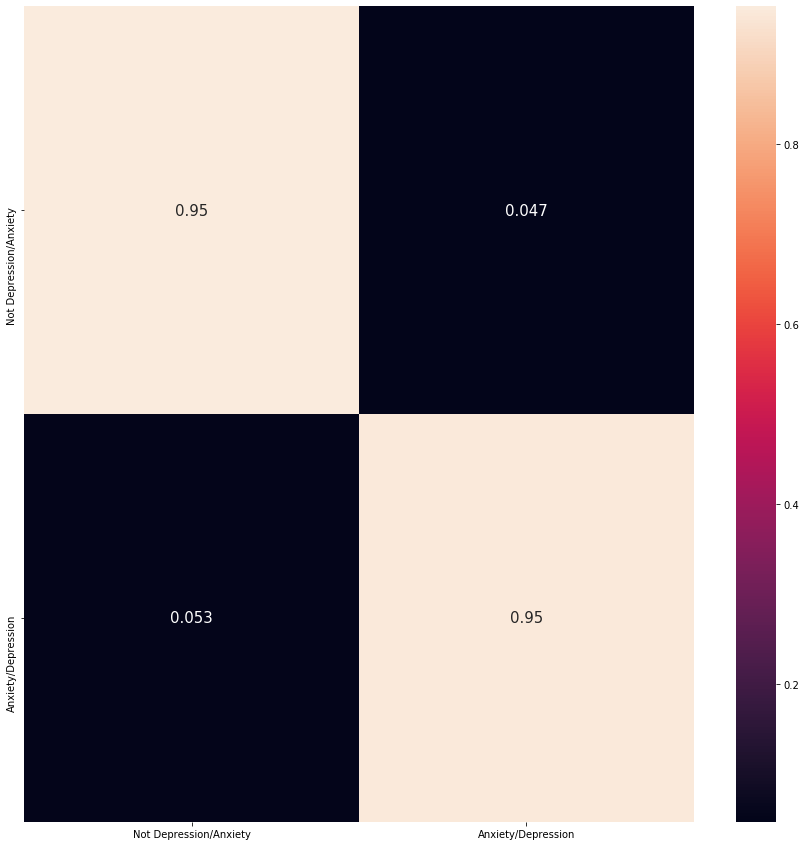

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Not Depression/Anxiety','Anxiety/Depression'],columns = ['Not Depression/Anxiety','Anxiety/Depression'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [46]:
# Make sure to call end_point.delete_endpoint()to delete the model endpoint.
# After go ahead and delete any files uploaded by sagemaker from your s3 bucket.
end_point.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)
